# Import Pycaret

In [207]:
%%capture

!pip install --upgrade packaging -q
!pip install pycaret[full] -q

# Importacao Bibliotecas

In [208]:
#importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.ensemble import(AdaBoostClassifier,
                            RandomForestClassifier,
                            GradientBoostingClassifier)

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from scipy import stats

from sklearn.preprocessing import (
                                   RobustScaler,
                                   OneHotEncoder,
                                   )

from sklearn.model_selection import (train_test_split as tts,
                                     cross_validate as cv)

from sklearn.dummy import DummyClassifier

from sklearn import set_config

from sklearn.linear_model import LogisticRegression

from lightgbm import  LGBMClassifier

from sklearn.neural_network import  MLPClassifier

from yellowbrick.classifier import (confusion_matrix,
                                  precision_recall_curve,
                                    roc_auc,
                                    classification_report)





import warnings

warnings.filterwarnings("ignore")

set_config("diagram")

sns.set(style = 'whitegrid')



# Funcoes para uso do case

In [209]:
# criando funcoes para metricas
def calculate_metrics(model, X, y):
        y_pred = model.predict(X)

        model_metrics = {
        'accuracy': metrics.accuracy_score(y, y_pred),
        'balanced_accuracy': metrics.balanced_accuracy_score(y, y_pred),
        'precision': metrics.precision_score(y, y_pred),
        'recall': metrics.recall_score(y, y_pred),
        'f1': metrics.f1_score(y, y_pred),
    }

        try:
            y_pred_proba = model.predict_proba(X)[:,1]
            model_metrics['roc-auc'] = metrics.roc_auc_score(y, y_pred_proba)
            return model_metrics
        except:
            return model_metrics

#extracao e tratamento e mudando de tipo de dados
def prep()->pd.DataFrame :
  df=pd.read_excel("/content/churn_data.xlsx")
  df["SeniorCitizen"]=df["SeniorCitizen"].astype("int16")
  df["tenure"]=df["tenure"].astype("int16")
  df["MonthlyCharges"]=df["MonthlyCharges"].astype("int16")
  df["TotalCharges"]=df["TotalCharges"].astype("int16")
  df.columns = df.columns.str.lower()
  df=df.sample(frac=1, random_state=101)


  return df

df=prep()

'''separando meu dataset em 2 diferentes, onde o holdoutset
vai ser utilizado no final como um dataset de avaliacao de modelo'''

hold_out=df.sample(n=1032,random_state=101).index

def splitdf()->pd.DataFrame:
  df_train=(df.loc[~df.index.isin(hold_out)]
  .sample(frac=1, random_state=101)
  .reset_index(drop=True)
  .drop(columns="customerid"))

  df_holdout=(df.loc[df.index.isin(hold_out)]
  .sample(frac=1, random_state=101)
  .reset_index(drop=True)
  .drop(columns="customerid"))

  return df_train, df_holdout

df_train,df_holdout=splitdf()

# Trabalhando com Pycaret

In [210]:
#importing classification package

from pycaret.classification import *


In [211]:
#setting parameters
churn=setup( data= df_train, target="churn", session_id=101,
            normalize=True,
             transformation=True,
             remove_multicollinearity=True,
             multicollinearity_threshold=0.95)

,Description,Value
0,Session id,101
1,Target,churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6000, 20)"
5,Transformed data shape,"(6000, 35)"
6,Transformed train set shape,"(4200, 35)"
7,Transformed test set shape,"(1800, 35)"
8,Ordinal features,5
9,Numeric features,4


In [212]:
#get models

best = compare_models()




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8081,0.8497,0.5249,0.6738,0.5880,0.4659,0.4732,1.0230
ridge,Ridge Classifier,0.8064,0.0000,0.4823,0.6894,0.5661,0.4466,0.4593,0.3270
gbc,Gradient Boosting Classifier,0.8060,0.8487,0.5350,0.6639,0.5913,0.4661,0.4715,1.0290
lda,Linear Discriminant Analysis,0.8048,0.8477,0.5259,0.6628,0.5849,0.4597,0.4659,0.4650
ada,Ada Boost Classifier,0.7995,0.8442,0.5177,0.6496,0.5742,0.4457,0.4517,0.4650
rf,Random Forest Classifier,0.7962,0.8286,0.4905,0.6494,0.5573,0.4285,0.4365,0.9340
lightgbm,Light Gradient Boosting Machine,0.7936,0.8346,0.5177,0.6331,0.5684,0.4346,0.4392,1.5300
xgboost,Extreme Gradient Boosting,0.7905,0.8281,0.5277,0.6195,0.5685,0.4316,0.4349,1.1850
et,Extra Trees Classifier,0.7798,0.8066,0.4705,0.6043,0.5280,0.3874,0.3932,0.6100
svm,SVM - Linear Kernel,0.7793,0.0000,0.5140,0.6019,0.5400,0.3997,0.4093,0.7970


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [213]:
#creating model
lr=create_model("lr", fold=5, round=2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.80,0.84,0.45,0.68,0.54,0.42,0.43
1,0.80,0.84,0.51,0.63,0.57,0.44,0.44
2,0.82,0.87,0.56,0.70,0.62,0.51,0.51
3,0.82,0.85,0.56,0.70,0.62,0.51,0.51
4,0.79,0.84,0.54,0.62,0.58,0.44,0.44
Mean,0.81,0.85,0.52,0.67,0.59,0.46,0.47
Std,0.01,0.01,0.04,0.03,0.03,0.04,0.04


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [214]:
#tunning model

lr_tune=tune_model(lr, optimize="recall")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.8288,0.4364,0.6857,0.5333,0.4140,0.4311
1,0.7905,0.8483,0.4364,0.6486,0.5217,0.3941,0.4068
2,0.7857,0.8388,0.5545,0.5980,0.5755,0.4324,0.4330
3,0.8071,0.8405,0.4636,0.6986,0.5574,0.4405,0.4556
4,0.8310,0.8788,0.5455,0.7407,0.6283,0.5221,0.5324
5,0.8238,0.8731,0.6000,0.6875,0.6408,0.5248,0.5269
6,0.8095,0.8269,0.5091,0.6829,0.5833,0.4633,0.4717
7,0.8476,0.8810,0.6091,0.7614,0.6768,0.5787,0.5848
8,0.7857,0.8330,0.5000,0.6111,0.5500,0.4112,0.4148


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Calibrating model

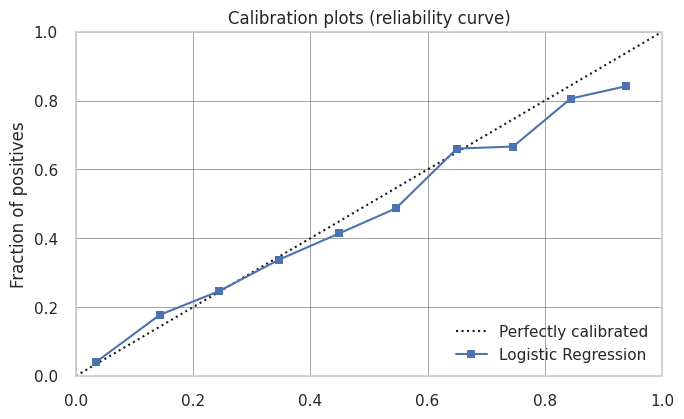

In [215]:
plot_model(lr, plot="calibration")

In [216]:
#calibrating model
calibrated_lr = calibrate_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7976,0.8283,0.4273,0.6812,0.5251,0.4050,0.4228
1,0.7905,0.8487,0.4273,0.6528,0.5165,0.3901,0.4044
2,0.7833,0.8386,0.5545,0.5922,0.5728,0.4278,0.4283
3,0.8071,0.8412,0.4636,0.6986,0.5574,0.4405,0.4556
4,0.8310,0.8789,0.5455,0.7407,0.6283,0.5221,0.5324
5,0.8190,0.8748,0.5909,0.6771,0.6311,0.5119,0.5140
6,0.8095,0.8272,0.5091,0.6829,0.5833,0.4633,0.4717
7,0.8476,0.8803,0.6091,0.7614,0.6768,0.5787,0.5848
8,0.7881,0.8338,0.4909,0.6207,0.5482,0.4123,0.4171


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

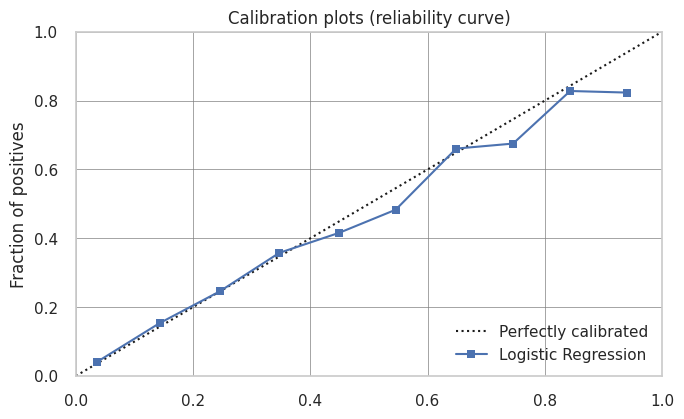

In [217]:
#ploting after calibration
plot_model( calibrated_lr, plot="calibration")

In [218]:
#isotonic calibration
iso_cal_lr=calibrate_model(lr, method="isotonic")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.8300,0.4273,0.6912,0.5281,0.4100,0.4291
1,0.7905,0.8461,0.4727,0.6341,0.5417,0.4096,0.4170
2,0.7810,0.8376,0.5636,0.5849,0.5741,0.4267,0.4268
3,0.8048,0.8415,0.4636,0.6892,0.5543,0.4354,0.4494
4,0.8405,0.8790,0.5909,0.7471,0.6599,0.5575,0.5641
5,0.8190,0.8744,0.6273,0.6635,0.6449,0.5236,0.5240
6,0.8095,0.8246,0.5091,0.6829,0.5833,0.4633,0.4717
7,0.8381,0.8780,0.6091,0.7283,0.6634,0.5579,0.5618
8,0.7905,0.8330,0.5273,0.6170,0.5686,0.4314,0.4337


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

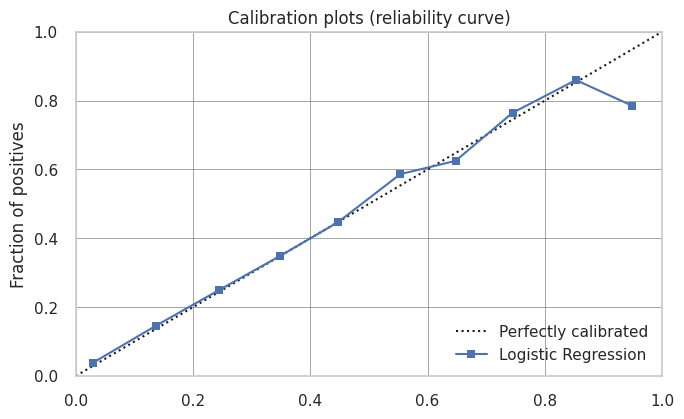

In [219]:
#plting calibration isotonic
plot_model( iso_cal_lr, plot="calibration")

In [220]:
#testing the calibrated model with as unseen model to check the metrics
unseen_pred= predict_model(iso_cal_lr, data=df_holdout)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8120,0.8629,0.8120,0.8051,0.8002,0.4934,0.5083


# EDA

In [221]:
# checando se existem valores faltantes no nosso dataset
df_train.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [222]:
'''analisando os valores de churn se estao com as mesma proporcao entre holdout
df_train '''
df_holdout.churn.value_counts()

No     736
Yes    296
Name: churn, dtype: int64

In [223]:
df_train.churn.value_counts()

No     4427
Yes    1573
Name: churn, dtype: int64

In [224]:
#checando duplicados na dataset de treino
df_train[df_train.duplicated(keep=False)].sort_values(df_train.columns.tolist())

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3080,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45,45,Yes
5250,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45,45,Yes
1524,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,45,45,No
4670,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,45,45,No
5305,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,45,45,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19,19,Yes
4434,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20,20,No
5473,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20,20,No
1901,Male,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19,19,No


In [225]:
#analise descritiva do nosso dataset nas colunas numericas

describe=df_train.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75,0.90, 0.99])

describe.style.background_gradient(axis=None)

,seniorcitizen,tenure,monthlycharges,totalcharges
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.165167,32.690667,64.505500,2299.839833
std,0.371362,24.588590,30.074891,2269.410846
min,0.000000,1.000000,18.000000,18.000000
1%,0.000000,1.000000,19.000000,19.000000
10%,0.000000,2.000000,20.000000,88.000000
25%,0.000000,9.000000,35.000000,415.000000
50%,0.000000,29.000000,70.000000,1413.500000
75%,0.000000,56.000000,89.000000,3813.000000
90%,1.000000,69.000000,102.000000,5991.600000


In [226]:
#analise descritiva do nosso dataset parte categorica
describe_ob=df_train.describe(exclude="number").T
describe_ob

,count,unique,top,freq
gender,6000,2,Male,3041
partner,6000,2,No,3094
dependents,6000,2,No,4212
phoneservice,6000,2,Yes,5430
multiplelines,6000,3,No,2867
internetservice,6000,3,Fiber optic,2647
onlinesecurity,6000,3,No,2973
onlinebackup,6000,3,No,2637
deviceprotection,6000,3,No,2612
techsupport,6000,3,No,2937


In [227]:
#separando as colunas numericas e colunas categoricas
cat_col=df_train.select_dtypes(exclude="number").columns
num_col=[col for col in df_train.columns if col not in cat_col ]

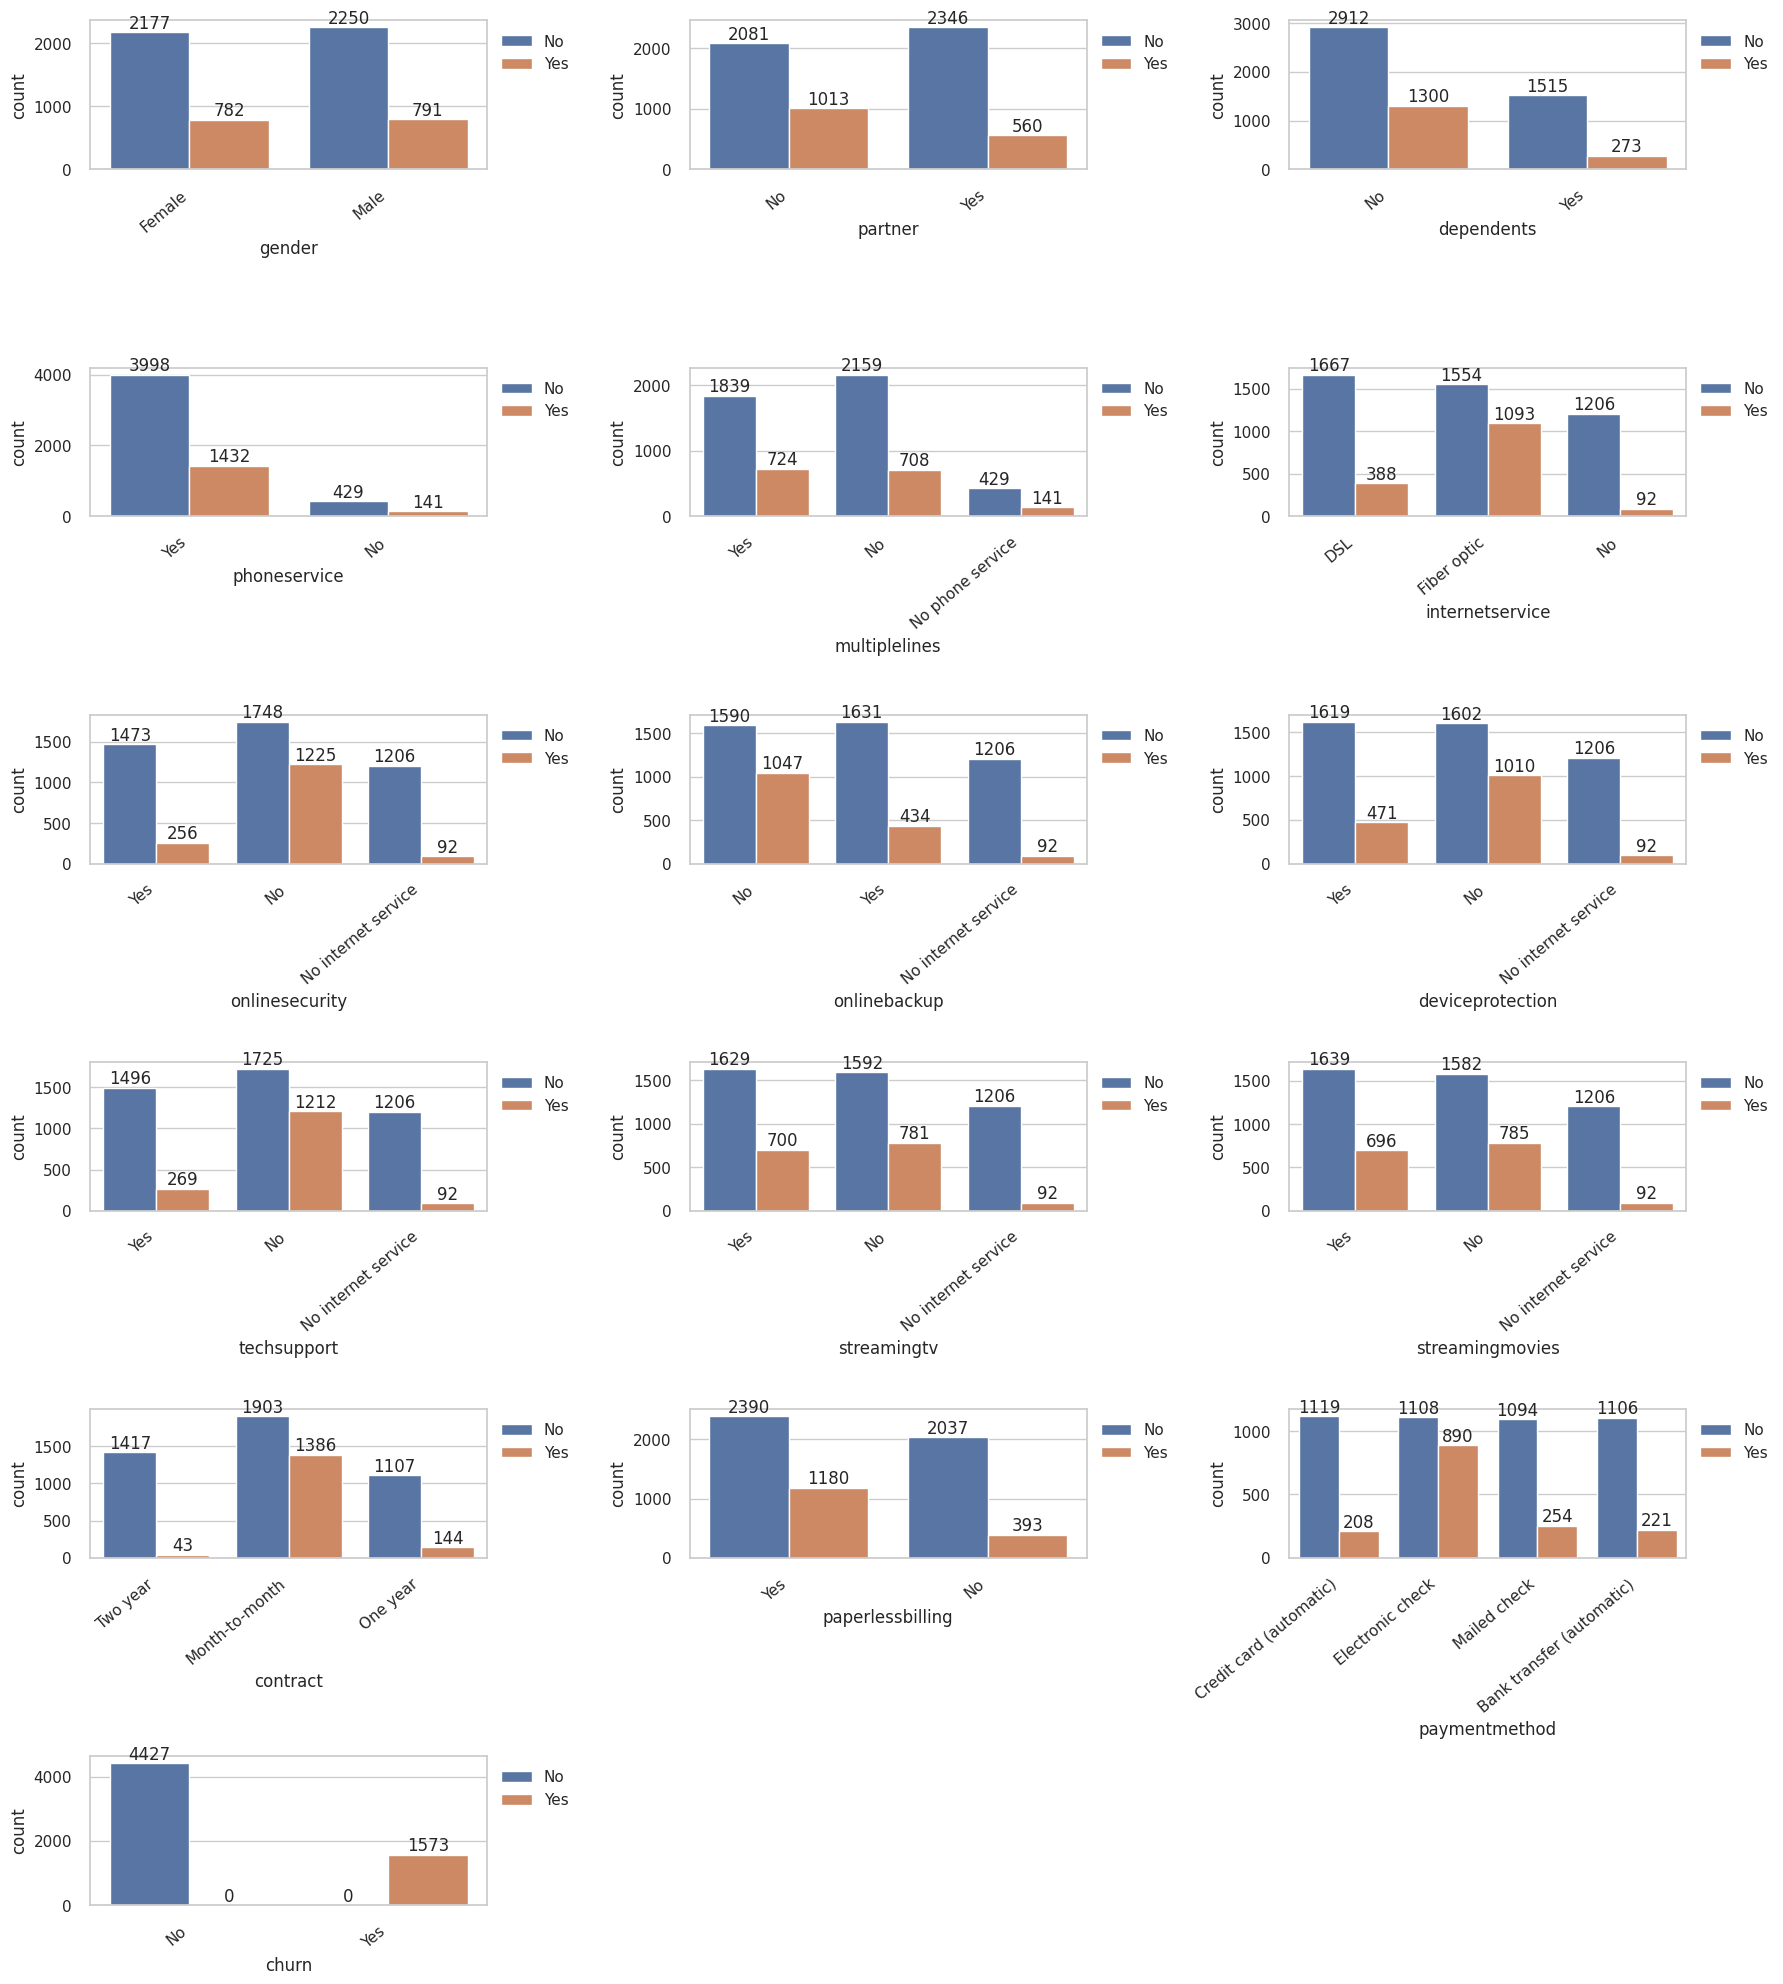

In [228]:
#plotagem de graficos para comparacao de variaveis categoricas x churn
plt.figure(figsize=(18,20))
for i, cat in enumerate(cat_col):
  ax=plt.subplot(6,3 , i+1)
  sns.countplot(data=df_train, x=cat, hue="churn")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  for label in ax.containers:
    ax.bar_label(label)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.tight_layout()




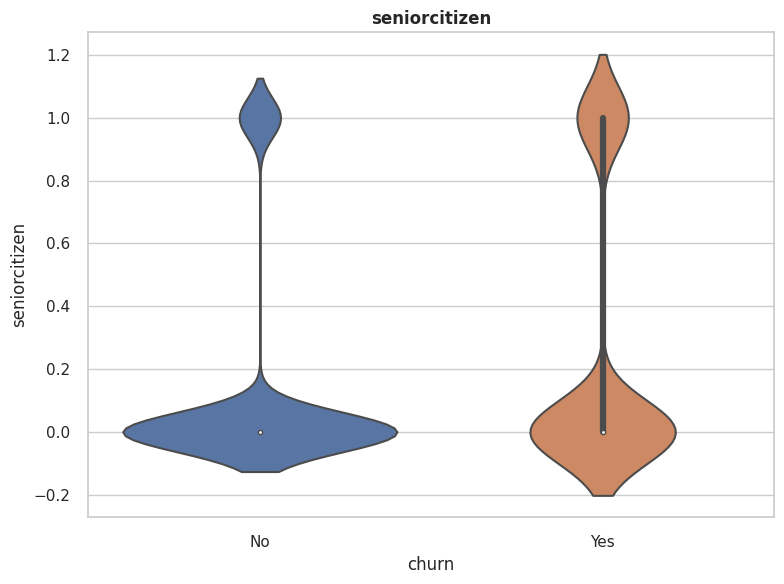

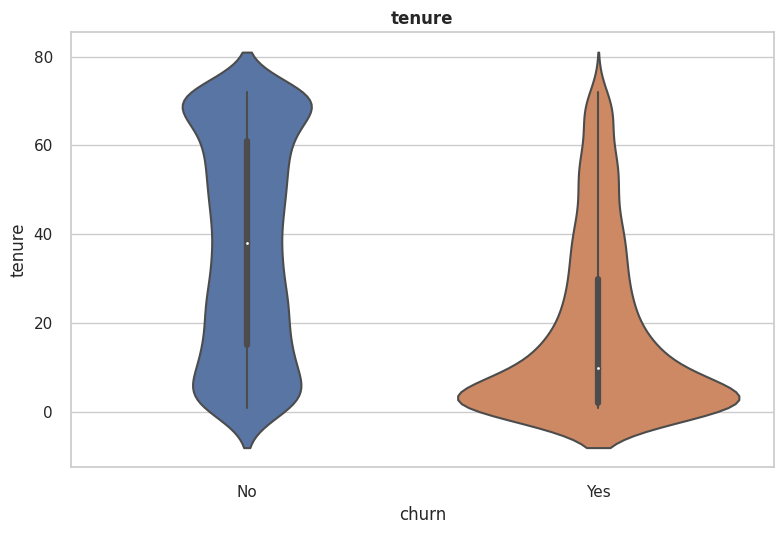

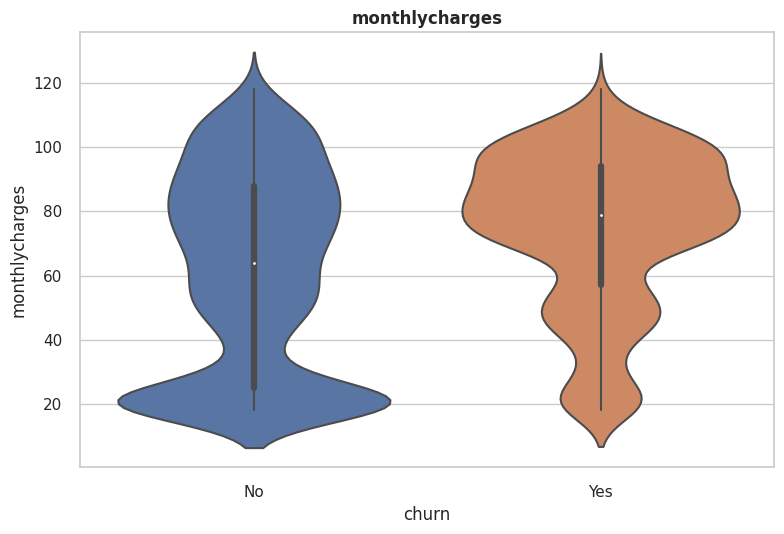

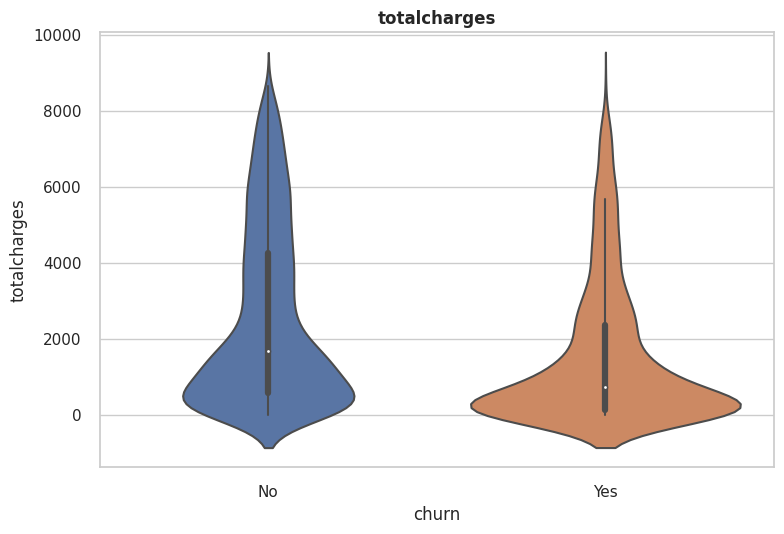

In [229]:
#violinplot para facilitar a visualizacao de como nosso Df esta distribuidos entre Churn e nao Churn
plt.figure(figsize=(8,6))
for col in num_col:
  sns.violinplot(data=df_train, x="churn", y=col , split=True)
  plt.title(col, weight="bold")
  plt.tight_layout()
  plt.show()

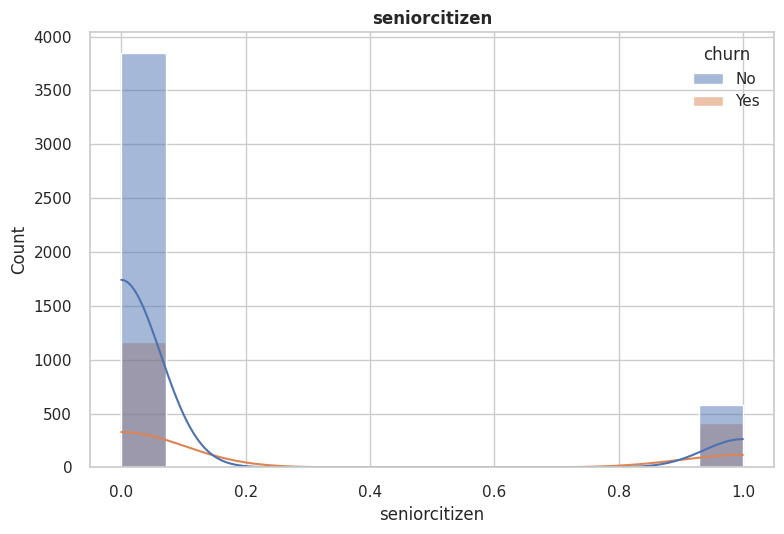

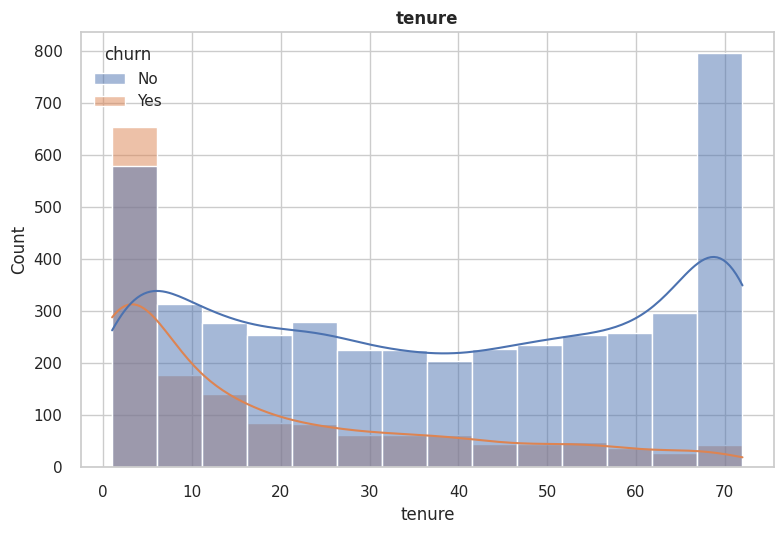

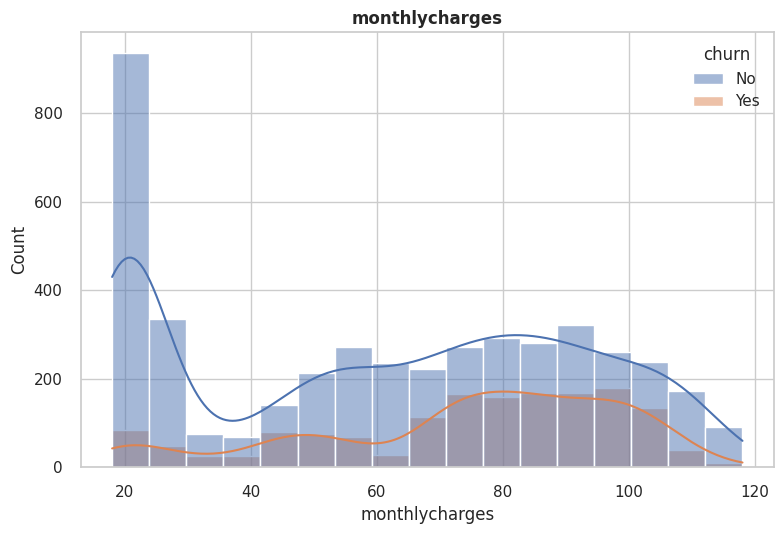

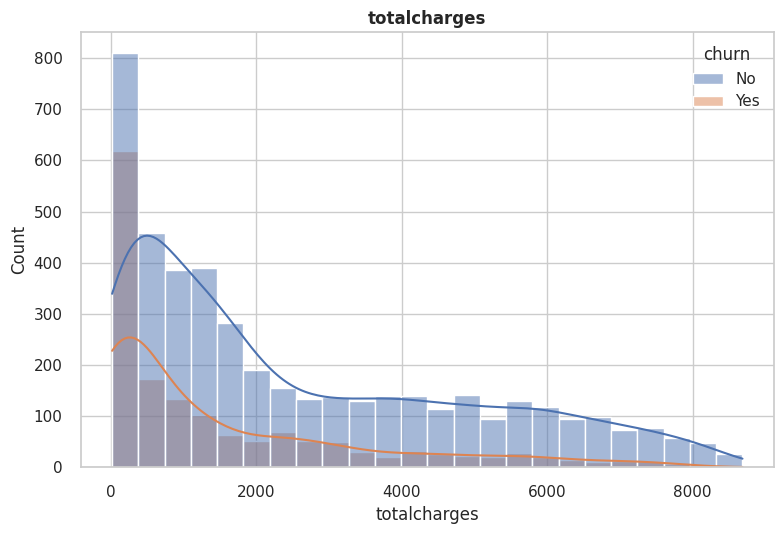

In [230]:
'''Plotagem de histograma para sobreposoto
para facilitar a comparacao da distribuicao entre CHURN x NAO CHURN'''
for col in num_col:
    sns.histplot(data=df_train, x=col, kde=True, hue="churn")
    plt.title(col,weight="bold")
    plt.tight_layout()
    plt.show()

# Analise estatisticas das variaveis

In [231]:
feature= "tenure"
a=df_train.loc[df_train.churn=="No", feature]
b=df_train.loc[df_train.churn=="Yes", feature]

stats.ttest_ind(a,b)

Ttest_indResult(statistic=28.970195626255894, pvalue=7.862071240143188e-173)

In [232]:
ttest_result={}
for num in num_col:
  a=df_train.loc[df_train.churn=="No", feature]
  b=df_train.loc[df_train.churn=="Yes", feature]
  pvalue=stats.ttest_ind(a,b).pvalue
  ttest_result[num]=pvalue

ttest_result

{'seniorcitizen': 7.862071240143188e-173,
 'tenure': 7.862071240143188e-173,
 'monthlycharges': 7.862071240143188e-173,
 'totalcharges': 7.862071240143188e-173}

In [233]:
pd.DataFrame([ttest_result]).T.round(5)

,0
seniorcitizen,0.0
tenure,0.0
monthlycharges,0.0
totalcharges,0.0


In [234]:
df_contingency=pd.crosstab(df_train.contract, df_train.churn)

In [235]:
chi_results={}

for cat in cat_col:
  df_contingency=pd.crosstab(df[cat], df.churn)
  pvalue=stats.chi2_contingency(df_contingency).pvalue
  chi_results[cat]=pvalue

chi_results

{'gender': 0.4904884707065509,
 'partner': 3.97379757451591e-36,
 'dependents': 2.0196592017051303e-42,
 'phoneservice': 0.34992398942431924,
 'multiplelines': 0.0035679273999811405,
 'internetservice': 5.831198962237274e-159,
 'onlinesecurity': 1.4006867477839222e-184,
 'onlinebackup': 7.776099238804965e-131,
 'deviceprotection': 1.9593887862403176e-121,
 'techsupport': 7.407807748843711e-180,
 'streamingtv': 1.324641113169159e-81,
 'streamingmovies': 5.353560421401324e-82,
 'contract': 7.326182186265472e-257,
 'paperlessbilling': 8.236203353962564e-58,
 'paymentmethod': 1.4263098511063342e-139,
 'churn': 0.0}

In [236]:
chi_value=pd.Series(chi_results).to_frame("p_value")
(chi_value
.sort_values("p_value", ascending=False)
.round(5)
.style.background_gradient())

,p_value
gender,0.490490
phoneservice,0.349920
multiplelines,0.003570
partner,0.000000
dependents,0.000000
paperlessbilling,0.000000
streamingtv,0.000000
streamingmovies,0.000000
deviceprotection,0.000000
onlinebackup,0.000000


# Modeling

In [237]:
enconde={"No":0,
         "Yes":1}

df_train["churn"]=df_train["churn"].map(enconde)

In [238]:
cat_col=[
          #'gender',
         'partner',
         'dependents',
         #'phoneservice',
         'multiplelines',
        'internetservice',
         'onlinesecurity',
         'onlinebackup',
         'deviceprotection',
        'techsupport',
         'streamingtv',
         'streamingmovies',
         'contract',
        'paperlessbilling',
         'paymentmethod',
         #'churn'
          ]

num_col
x=cat_col+num_col

y="churn"

In [239]:
df_train[y]

0       0
1       1
2       1
3       0
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: churn, Length: 6000, dtype: int64

In [240]:
x_train, x_test, y_train, y_test = tts( df_train[x], df_train[y], random_state=101, stratify=df_train[y])

In [241]:
# List com tuplas, onde, cada tupla, tem os 3 seguintes elementos:
# nome - transformador - variaveis
preprocessor=ColumnTransformer([
    ("scaler",RobustScaler(), num_col),
    ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_col)
])

pipe=Pipeline([
    ("preprocessing", preprocessor),
    ("model", LogisticRegression())
])

pipe

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaler',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               unit_variance=False,
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder',
                                                  OneHotEn...
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [242]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaler',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               unit_variance=False,
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder',
                                                  OneHotEn...
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [243]:
#metricas de avaliacao  da Regressao Logistica

calculate_metrics(pipe, x_test, y_test)

{'accuracy': 0.7986666666666666,
 'balanced_accuracy': 0.7109649213540481,
 'precision': 0.6408668730650154,
 'recall': 0.5267175572519084,
 'f1': 0.5782122905027933,
 'roc-auc': 0.8318254641409857}

In [244]:
#treinamento e metricas usando random forest
pipe.set_params(model=RandomForestClassifier()).fit(x_train, y_train)
calculate_metrics(pipe, x_test, y_test)

{'accuracy': 0.77,
 'balanced_accuracy': 0.6636428832481709,
 'precision': 0.5805369127516778,
 'recall': 0.4402035623409669,
 'f1': 0.5007235890014472,
 'roc-auc': 0.7999326515741833}

In [245]:
#passando dicionario de modelos e instancinando

models = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(class_weight="balanced"),
    'rf': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "neural": MLPClassifier(hidden_layer_sizes=(50,100,150), activation="logistic")
}



In [246]:
#calculando

results = []

for model_name, modelo in models.items():
  print(modelo)
  pipe.set_params(model=modelo).fit(x_train, y_train)
  result=calculate_metrics(pipe, x_test, y_test)
  results.append(result)
  print(results)









DummyClassifier(constant=None, random_state=None, strategy='prior')
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}]
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.74, 'balanced_accuracy': 0.7532772019832158, 'precision': 0.502454991816694, 'recall': 0.7811704834605598, 'f1': 0.6115537848605578, 'roc-auc': 0.8319311988709369}]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_sampl

In [247]:
df_results=pd.DataFrame(results).T

In [248]:
df_results.columns=[
    'dummy',
    'lr',
    'rf',
    'gbc',
    "ada",
    "lgbm",
    "neural"]

In [249]:
df_results.style.background_gradient(axis=0)

,dummy,lr,rf,gbc,ada,lgbm,neural
accuracy,0.738000,0.740000,0.768000,0.793333,0.783333,0.786000,0.797333
balanced_accuracy,0.500000,0.753277,0.664750,0.702428,0.687447,0.702383,0.691188
precision,0.000000,0.502455,0.573290,0.630094,0.608280,0.605263,0.659498
recall,0.000000,0.781170,0.447837,0.511450,0.486005,0.526718,0.468193
f1,0.000000,0.611554,0.502857,0.564607,0.540311,0.563265,0.547619
roc-auc,0.500000,0.831931,0.795638,0.828027,0.830808,0.820167,0.833752


#UnderSampling

Undersampling

In [250]:
# Class count
count_class_zero, count_class_one=df_train["churn"].value_counts()


In [251]:
df_class_zero=df_train[df_train["churn"]==0]
df_class_one=df_train[df_train["churn"]==1]
print(f"Shape of No churn {df_class_zero.shape},\
Shape of churn {df_class_one.shape}")

Shape of No churn (4427, 20),Shape of churn (1573, 20)


In [252]:
#undersampling class zero ( No churn) using my class count one
df_class_zero=df_class_zero.sample(n=count_class_one)

# concat the DataFrame then check the value counts
df_undersampling=pd.concat([df_class_one, df_class_zero])
print("Random undersampling")
df_undersampling.churn.value_counts()

Random undersampling


1    1573
0    1573
Name: churn, dtype: int64

In [253]:
catunder_col=df_undersampling.select_dtypes(exclude="number").columns
numunder_col=[col for col in df_undersampling.columns if col not in catunder_col]

In [254]:
catunder_col=[
    #'gender',
    'partner',
    'dependents',
    #'phoneservice',
    'multiplelines',
   'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod'
    ]
numunder_col=['seniorcitizen',
              'tenure',
              'monthlycharges',
              'totalcharges',
             # 'churn'
              ]



In [255]:
 x_under= catunder_col + numunder_col
 y_under=df_undersampling["churn"]

In [256]:
df_undersampling[x_under]

,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,seniorcitizen,tenure,monthlycharges,totalcharges
1,Yes,No,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,1,29,95,2745
2,No,No,No,Fiber optic,Yes,No,No,No,No,Yes,Month-to-month,No,Mailed check,1,47,85,4042
4,Yes,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),0,24,99,2431
16,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),0,12,19,229
18,Yes,No,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0,1,95,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0,23,91,2198
4628,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0,18,71,1247
825,No,No,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,No,Electronic check,0,5,96,500
1201,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic),0,45,73,3371


In [257]:
#train test split from my new undersampling dataframe
x_under_train, x_under_test, y_under_train, y_under_test= tts(df_undersampling[x_under],y_under, random_state=101, stratify= y_under)

In [258]:
#preprocessing
preprocessor_under=ColumnTransformer([
    ("scaler_under",RobustScaler(), numunder_col),
    ("encoder_under", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), catunder_col)
])

pipe_under=Pipeline([
    ("preprocessing", preprocessor_under),
    ("model", LogisticRegression())
])
pipe_under

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaler_under',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               unit_variance=False,
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder_und...
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [259]:
pipe_under.fit(x_under_train,y_under_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaler_under',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               unit_variance=False,
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder_und...
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [260]:
#calculando as metricas

calculate_metrics(pipe_under,x_under_test, y_under_test)

{'accuracy': 0.7789072426937739,
 'balanced_accuracy': 0.778874594748195,
 'precision': 0.7657004830917874,
 'recall': 0.8045685279187818,
 'f1': 0.7846534653465347,
 'roc-auc': 0.8630830136526264}

In [261]:
#passando balanced para class weight para entender se modelo sofre alguma penalidade.
pipe_under.set_params(model=LogisticRegression(class_weight="balanced")).fit(x_under_train, y_under_train)
calculate_metrics(pipe_under, x_under_test, y_under_test)



{'accuracy': 0.7789072426937739,
 'balanced_accuracy': 0.778874594748195,
 'precision': 0.7657004830917874,
 'recall': 0.8045685279187818,
 'f1': 0.7846534653465347,
 'roc-auc': 0.8630765554565298}

In [262]:
models_under = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "neural": MLPClassifier(hidden_layer_sizes=(50,100,150), activation="logistic")
}

In [263]:
results_under = []

for model_name, modelo in models_under.items():
  print(modelo)
  pipe_under.set_params(model=modelo).fit(x_under_train, y_under_train)
  result=calculate_metrics(pipe_under, x_under_test, y_under_test)
  results_under.append(result)
  print(results_under)


DummyClassifier(constant=None, random_state=None, strategy='prior')
[{'accuracy': 0.4993646759847522, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[{'accuracy': 0.4993646759847522, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.7789072426937739, 'balanced_accuracy': 0.778874594748195, 'precision': 0.7657004830917874, 'recall': 0.8045685279187818, 'f1': 0.7846534653465347, 'roc-auc': 0.8630830136526264}]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                   

In [264]:
df_results_under=pd.DataFrame(results_under).T

In [265]:
df_results_under.columns=[
    'dummy',
    'lr',
    'rf',
    'gbc',
    "ada",
    "lgbm",
    "neural"]

In [266]:

df_results_under.style.background_gradient(axis=0)

,dummy,lr,rf,gbc,ada,lgbm,neural
accuracy,0.499365,0.778907,0.757306,0.776366,0.768742,0.766201,0.780178
balanced_accuracy,0.500000,0.778875,0.757311,0.776337,0.768716,0.766204,0.780173
precision,0.000000,0.765700,0.759591,0.764563,0.758537,0.767857,0.778338
recall,0.000000,0.804569,0.753807,0.799492,0.789340,0.763959,0.784264
f1,0.000000,0.784653,0.756688,0.781638,0.773632,0.765903,0.781290
roc-auc,0.500000,0.863083,0.842601,0.859773,0.857978,0.848052,0.865544


# Oversampling Train sets

In [267]:
#selecting my columns
cat_col1=df_train.select_dtypes(exclude="number").columns
num_col1=[col for col in df_train.columns if col not in cat_col1]

In [268]:

cat_col1=[
    #'gender',
    'partner',
    'dependents',
    #'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod'
    ]


num_col1=['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges',
             #'churn'
             ]


x1=cat_col1 + num_col1
y1="churn"

In [269]:
x1=cat_col1 + num_col1
y1="churn"

In [270]:
x1_train, x1_test, y1_train, y1_test = tts( df_train[x1], df_train[y1], stratify = df_train[y1])

In [271]:
count_class_zero1, count_class_one1= y1_train.value_counts()

print(count_class_zero1, count_class_one1)


3320 1180


In [272]:
#concat x_train, y_train
data_train = pd.concat([x1_train, y1_train], axis=1)

In [273]:
#oversampling the class 1
data_train_class0=data_train[data_train["churn"]==0]
data_train_class1=data_train[data_train["churn"]==1]
print(f"Shape of No churn {data_train_class0.shape},\
Shape of churn {data_train_class1.shape}")
data_train_class1=data_train_class1.sample(n=count_class_zero1, replace=True)


Shape of No churn (3320, 18),Shape of churn (1180, 18)


In [274]:
data_train=pd.concat([data_train_class0, data_train_class1])
data_train.head(1)


,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,seniorcitizen,tenure,monthlycharges,totalcharges,churn
1599,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,30,19,599,0


In [275]:
#spliting my x_train, y_train again
x1_train=data_train.iloc[:,:-1]
y1_train=data_train.iloc[:,-1]


In [276]:
#preprocessing
preprocessor_over=ColumnTransformer([
    ("scaler_over",RobustScaler(), num_col1),
    ("encoder_over", OneHotEncoder(drop="if_binary", handle_unknown="ignore",sparse_output=False), cat_col1)
])

pipe_over1=Pipeline([
    ("preprocessing", preprocessor_over),
    ("model", LogisticRegression())
])
pipe_over1

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaler_over',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               unit_variance=False,
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder_over...
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [277]:
pipe_over1.fit(x1_train, y1_train)
calculate_metrics(pipe_over1, x1_test, y1_test)

{'accuracy': 0.7533333333333333,
 'balanced_accuracy': 0.758207658412462,
 'precision': 0.5197934595524957,
 'recall': 0.7684478371501272,
 'f1': 0.6201232032854209,
 'roc-auc': 0.8446492480191977}

In [278]:
models_over1 = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "neural": MLPClassifier(hidden_layer_sizes=(50,100,150), activation="logistic")
}

In [279]:
#compare with other models
results_over1 = []

for model_name, modelo in models_over1.items():
  print(modelo)
  pipe_over1.set_params(model=modelo).fit(x1_train, y1_train)
  result1=calculate_metrics(pipe_over1,  x1_test, y1_test)
  results_over1.append(result1)
  print(results_over1)

DummyClassifier(constant=None, random_state=None, strategy='prior')
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.7533333333333333, 'balanced_accuracy': 0.758207658412462, 'precision': 0.5197934595524957, 'recall': 0.7684478371501272, 'f1': 0.6201232032854209, 'roc-auc': 0.8446492480191977}]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, m

In [280]:
df_results_over1=pd.DataFrame(results_over1).T
df_results_over1.columns=[
    'dummy',
    'lr',
    'rf',
    'gbc',
    "ada",
    "lgbm",
    "neural"]

In [281]:
df_results_over1.style.background_gradient(cmap = "PuBu_r", axis=0)

,dummy,lr,rf,gbc,ada,lgbm,neural
accuracy,0.738000,0.753333,0.798000,0.763333,0.757333,0.775333,0.766667
balanced_accuracy,0.500000,0.758208,0.737593,0.761700,0.769124,0.759163,0.759856
precision,0.000000,0.519793,0.615385,0.534050,0.524370,0.554475,0.539595
recall,0.000000,0.768448,0.610687,0.758270,0.793893,0.725191,0.745547
f1,0.000000,0.620123,0.613027,0.626709,0.631579,0.628445,0.626068
roc-auc,0.500000,0.844649,0.829445,0.849876,0.848669,0.838829,0.844601


# Oversampling

In [282]:
#count_values
count_class_zero, count_class_one=df_train["churn"].value_counts()

In [283]:

df_class_zero=df_train[df_train["churn"]==0]
df_class_one=df_train[df_train["churn"]==1]
print(f"Shape of No churn {df_class_zero.shape},\
Shape of churn {df_class_one.shape}")
df_class_one=df_class_one.sample(n=count_class_zero, replace=True)

Shape of No churn (4427, 20),Shape of churn (1573, 20)


In [284]:
#oversampling class zero ( No churn) using my class count one
df_class_one=df_class_one.sample(n=count_class_zero, replace=True)

# concat the DataFrame then check the value counts
df_oversampling=pd.concat([df_class_one, df_class_zero])
print("Random oversampling")
df_oversampling.churn.value_counts()


Random oversampling


1    4427
0    4427
Name: churn, dtype: int64

In [285]:
#spliting  categorical columns and numerical columns

catover_col=df_oversampling.select_dtypes(exclude="number").columns
numover_col=[col for col in df_oversampling.columns if col not in catunder_col]

In [286]:
catover_col=[
    #'gender',
    'partner',
    'dependents',
    #'phoneservice',
    'multiplelines',
   'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod'
    ]
numover_col=['seniorcitizen',
              'tenure',
              'monthlycharges',
              'totalcharges',
             # 'churn'
              ]

In [287]:
x_over= catover_col + numover_col
y_over=df_oversampling["churn"]

In [288]:
x_over_train, x_over_test, y_over_train, y_over_test = tts(df_oversampling[x_over],y_over, random_state=101, stratify= y_over)

In [289]:
#preprocessing
preprocessor_over=ColumnTransformer([
    ("scaler_over",RobustScaler(), numunder_col),
    ("encoder_over", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), catunder_col)
])

pipe_over=Pipeline([
    ("preprocessing", preprocessor_over),
    ("model", LogisticRegression())
])
pipe_over

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaler_over',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               unit_variance=False,
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder_over...
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [290]:
# fit and metrics
pipe_over.fit(x_over_train, y_over_train)
calculate_metrics(pipe_over, x_over_test, y_over_test)

{'accuracy': 0.7728093947606143,
 'balanced_accuracy': 0.7728093947606143,
 'precision': 0.7483552631578947,
 'recall': 0.8220415537488708,
 'f1': 0.7834696513129573,
 'roc-auc': 0.850132074039801}

In [291]:
#assuming new params, fitting and showing metrics
pipe_over.set_params(model=LogisticRegression(class_weight="balanced"))
pipe_over.fit(x_over_train, y_over_train)
calculate_metrics(pipe_over, x_over_test, y_over_test)

{'accuracy': 0.7728093947606143,
 'balanced_accuracy': 0.7728093947606143,
 'precision': 0.7483552631578947,
 'recall': 0.8220415537488708,
 'f1': 0.7834696513129573,
 'roc-auc': 0.850132074039801}

In [292]:
models_over = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "neural": MLPClassifier(hidden_layer_sizes=(50,100,150), activation="logistic")
}

In [293]:
#compare with other models
results_over = []

for model_name, modelo in models_over.items():
  print(modelo)
  pipe_over.set_params(model=modelo).fit(x_over_train, y_over_train)
  result=calculate_metrics(pipe_over, x_over_test, y_over_test)
  results_over.append(result)
  print(results_over)

DummyClassifier(constant=None, random_state=None, strategy='prior')
[{'accuracy': 0.5, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[{'accuracy': 0.5, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.7728093947606143, 'balanced_accuracy': 0.7728093947606143, 'precision': 0.7483552631578947, 'recall': 0.8220415537488708, 'f1': 0.7834696513129573, 'roc-auc': 0.850132074039801}]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_s

In [294]:
df_results_over=pd.DataFrame(results_over).T
df_results_over.columns=[
    'dummy',
    'lr',
    'rf',
    'gbc',
    "ada",
    "lgbm",
    "neural"]


In [295]:
df_results_over.style.background_gradient(axis=0)

,dummy,lr,rf,gbc,ada,lgbm,neural
accuracy,0.500000,0.772809,0.889341,0.795393,0.774616,0.851400,0.777326
balanced_accuracy,0.500000,0.772809,0.889341,0.795393,0.774616,0.851400,0.777326
precision,0.000000,0.748355,0.847581,0.765854,0.747154,0.809221,0.734351
recall,0.000000,0.822042,0.949413,0.850949,0.830172,0.919603,0.869015
f1,0.000000,0.783470,0.895611,0.806162,0.786478,0.860888,0.796028
roc-auc,0.500000,0.850132,0.962271,0.873077,0.855337,0.913033,0.855302


# Cross validation

In [296]:
models_cross = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(class_weight="balanced"),
    'rf': RandomForestClassifier(class_weight="balanced"),
    'gbc': GradientBoostingClassifier(),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "neural": MLPClassifier(hidden_layer_sizes=(50,100,150), activation="logistic")
}

cross_results = []

for model_name, modelo in models_cross.items():
  print(model_name, modelo)
  pipe.set_params(model=modelo)
  cross=cv(pipe, x_train, y_train, n_jobs=-1, cv=5, scoring=["precision", "accuracy", "f1","recall", "roc_auc" ])
  cross_result=pd.DataFrame(cross).mean().to_frame(model_name).T
  cross_results.append(cross_result)


df_cross=pd.concat(cross_results)

dummy DummyClassifier(constant=None, random_state=None, strategy='prior')
lr LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
rf RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
gbc GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,


In [297]:
df_cross_sort=(df_cross.sort_values("test_recall", ascending=False).style.background_gradient(axis=0, vmin=0.77, vmax=0.85))


In [298]:
df_cross_sort

,fit_time,score_time,test_precision,test_accuracy,test_f1,test_recall,test_roc_auc
lr,0.067993,0.030627,0.516730,0.750889,0.627967,0.800847,0.843783
neural,6.994380,0.054120,0.628261,0.797778,0.590458,0.558475,0.842569
gbc,0.774313,0.033443,0.671364,0.810000,0.599287,0.541525,0.847528
lgbm,0.124540,0.041550,0.643713,0.800000,0.584193,0.535593,0.832178
ada,0.269729,0.056808,0.650120,0.800667,0.579153,0.523729,0.845351
rf,0.493272,0.076969,0.621320,0.790000,0.561605,0.512712,0.823975
dummy,0.034263,0.028700,0.000000,0.737778,0.000000,0.000000,0.500000


# Cross validation oversampling

In [299]:
models_cross_over1 = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "neural": MLPClassifier(hidden_layer_sizes=(50,100,150), activation="logistic")
}

cross_results_over1 = []

for model_name, modelo in models_cross_over1.items():
  print(model_name, modelo)
  pipe_over1.set_params(model=modelo)
  cross_over1=cv(pipe_over1, x1_train, y1_train, n_jobs=-1, cv=5, scoring=["precision", "accuracy", "f1","recall", "roc_auc" ])
  results_over1=pd.DataFrame(cross_over1).mean().to_frame(model_name).T
  cross_results_over1.append(results_over1)


df_cross_over1=pd.concat(cross_results_over1)


dummy DummyClassifier(constant=None, random_state=None, strategy='prior')
lr LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
rf RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
gbc GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
            

In [300]:
df_cross_over1_sort=(df_cross_over1.sort_values("test_recall", ascending=False).style.background_gradient(axis=0, vmin=0.77, vmax=0.85))

In [301]:
df_cross_over1_sort

,fit_time,score_time,test_precision,test_accuracy,test_f1,test_recall,test_roc_auc
rf,0.642919,0.100270,0.847216,0.891416,0.897924,0.955120,0.961237
lgbm,0.308602,0.087697,0.802393,0.841717,0.851403,0.906928,0.907525
gbc,1.407784,0.049986,0.763489,0.793524,0.804662,0.850602,0.870824
neural,19.409571,0.050554,0.747885,0.775000,0.786856,0.831325,0.855327
ada,0.715064,0.139118,0.749914,0.775301,0.786307,0.826506,0.855765
lr,0.089115,0.032554,0.748146,0.770030,0.779863,0.814458,0.849563
dummy,0.040053,0.032970,0.000000,0.500000,0.000000,0.000000,0.500000


# Ploting Confusion matrix, ROC-AUC curve, Precision-Recall Curve

In [311]:
preprocessor=ColumnTransformer([
    ("scaler",RobustScaler(), num_col),
    ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_col)
])

pipe=Pipeline([
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(class_weight ="balanced"))
])

pipe.fit(x_train, y_train)
calculate_metrics(pipe, x_test, y_test)

{'accuracy': 0.74,
 'balanced_accuracy': 0.7532772019832158,
 'precision': 0.502454991816694,
 'recall': 0.7811704834605598,
 'f1': 0.6115537848605578,
 'roc-auc': 0.8319311988709369}

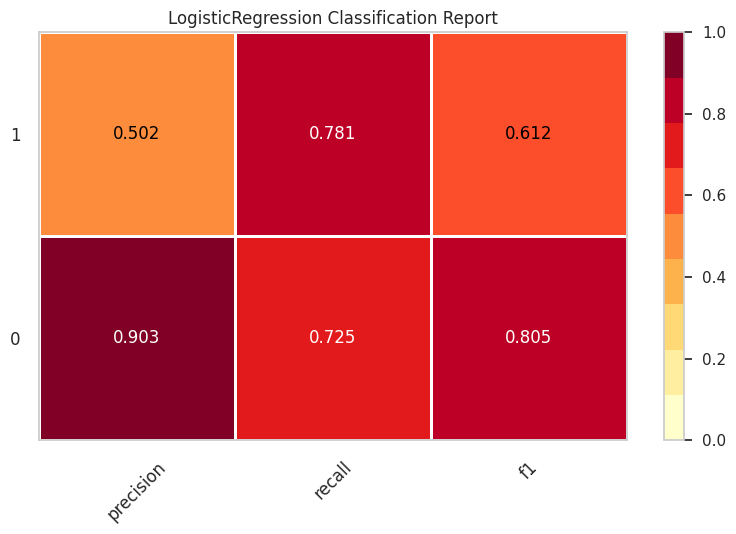

ClassificationReport(ax=<Axes: title={'center': 'LogisticRegression Classification Report'}>,
                     classes=None,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7e27c37e7010>,
                     colorbar=True, encoder=None,
                     estimator=Pipeline(memory=None,
                                        steps=[('preprocessing',
                                                ColumnTransformer(n_jobs=None,
                                                                  remainder='drop',
                                                                  sparse_threshold=0.3,
                                                                  transformer_weights=None,
                                                                  transformer...
                                                                  verbose_feature_names_out=True)),
                                               ('model',
                                                LogisticRegression(C=1.0,
                                                                   class_weight='balanced',
                                                                   dual=False,
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=100,
                                                                   multi_class='auto',
                                                                   n_jobs=None,
                                                                   penalty='l2',
                                                                   random_state=None,
                                                                   solver='lbfgs',
                                                                   tol=0.0001,
                                                                   verbose=0,
                                                                   warm_start=False))],
                                        verbose=False),
                     fontsize=None, force_model=False, is_fitted='auto',
                     support=None)

In [312]:
classification_report(pipe, x_train, y_train, x_test, y_test)

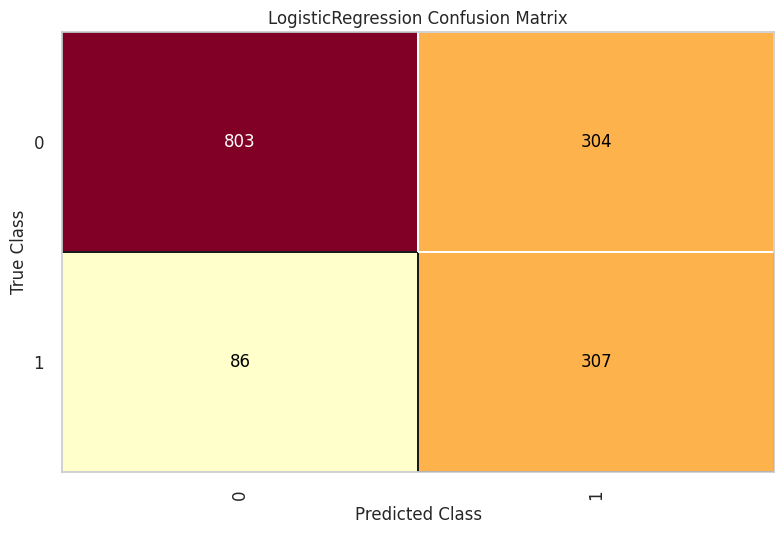

ConfusionMatrix(ax=<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=None,
                cmap=<matplotlib.colors.ListedColormap object at 0x7e27cd53f100>,
                encoder=None,
                estimator=Pipeline(memory=None,
                                   steps=[('preprocessing',
                                           ColumnTransformer(n_jobs=None,
                                                             remainder='drop',
                                                             sparse_threshold=0.3,
                                                             transformer_weigh...
                                          ('model',
                                           LogisticRegression(C=1.0,
                                                              class_weight='balanced',
                                                              dual=False,
                                                              fit_intercept=True,
                                                              intercept_scaling=1,
                                                              l1_ratio=None,
                                                              max_iter=100,
                                                              multi_class='auto',
                                                              n_jobs=None,
                                                              penalty='l2',
                                                              random_state=None,
                                                              solver='lbfgs',
                                                              tol=0.0001,
                                                              verbose=0,
                                                              warm_start=False))],
                                   verbose=False),
                fontsize=None, force_model=False, is_fitted='auto',
                percent=False, sample_weight=None)

In [304]:
confusion_matrix(pipe, x_train, y_train, x_test, y_test)

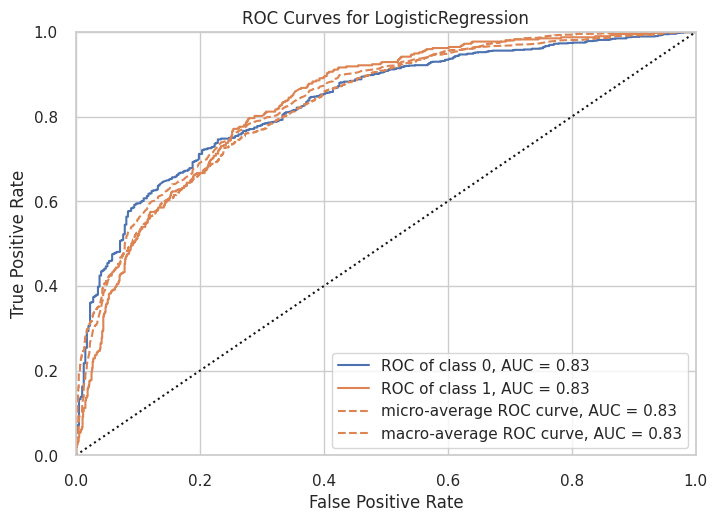

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=False, classes=None, encoder=None,
       estimator=Pipeline(memory=None,
                          steps=[('preprocessing',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('scaler',
                                                                   RobustScaler(copy=T...
                                                    verbose_feature_names_out=True)),
                                 ('model',
                                  LogisticRegression(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False))],
                          verbose=False),
       force_model=False, is_fitted='auto', macro=True, micro=True,
       per_class=True)

In [305]:
roc_auc (pipe, x_train, y_train, x_test, y_test)

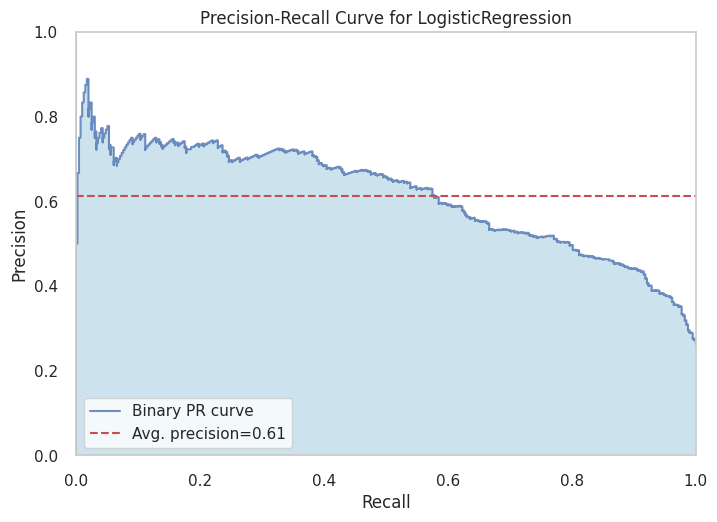

PrecisionRecallCurve(ap_score=True,
                     ax=<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>,
                     classes=None, cmap=None, colors=None, encoder=None,
                     estimator=Pipeline(memory=None,
                                        steps=[('preprocessing',
                                                ColumnTransformer(n_jobs=None,
                                                                  remainder='drop',
                                                                  sparse_threshold=0.3,
                                                                  transformer_weights=None,
                                                                  transformers...
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=100,
                                                                   multi_class='auto',
                                                                   n_jobs=None,
                                                                   penalty='l2',
                                                                   random_state=None,
                                                                   solver='lbfgs',
                                                                   tol=0.0001,
                                                                   verbose=0,
                                                                   warm_start=False))],
                                        verbose=False),
                     fill_area=True, fill_opacity=0.2, force_model=False,
                     is_fitted='auto', iso_f1_curves=False,
                     iso_f1_values={0.2, 0.4, 0.6, 0.8}, line_opacity=0.8,
                     micro=True, per_class=False)

In [314]:
precision_recall_curve(pipe, x_train, y_train, x_test, y_test)

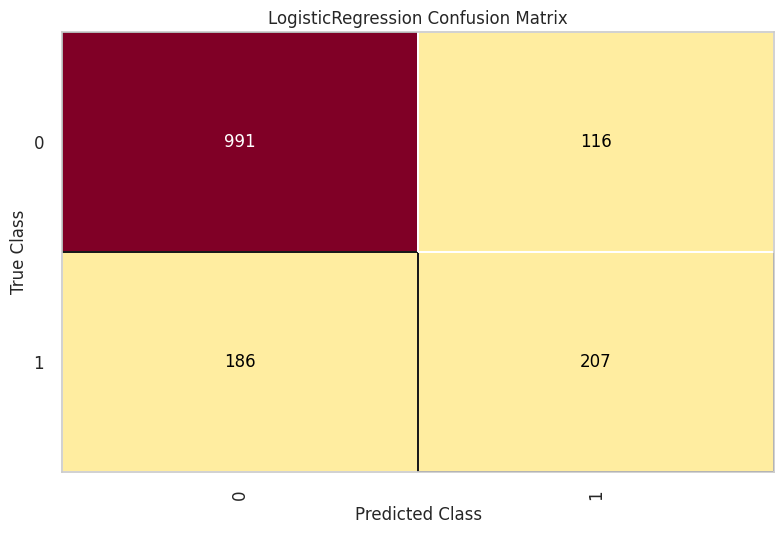

ConfusionMatrix(ax=<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=None,
                cmap=<matplotlib.colors.ListedColormap object at 0x7e27d48700d0>,
                encoder=None,
                estimator=Pipeline(memory=None,
                                   steps=[('preprocessing',
                                           ColumnTransformer(n_jobs=None,
                                                             remainder='drop',
                                                             sparse_threshold=0.3,
                                                             transformer_weigh...
                                                             verbose_feature_names_out=True)),
                                          ('model',
                                           LogisticRegression(C=1.0,
                                                              class_weight=None,
                                                              dual=False,
                                                              fit_intercept=True,
                                                              intercept_scaling=1,
                                                              l1_ratio=None,
                                                              max_iter=100,
                                                              multi_class='auto',
                                                              n_jobs=None,
                                                              penalty='l2',
                                                              random_state=None,
                                                              solver='lbfgs',
                                                              tol=0.0001,
                                                              verbose=0,
                                                              warm_start=False))],
                                   verbose=False),
                fontsize=None, force_model=False, is_fitted='auto',
                percent=False, sample_weight=None)

In [309]:
pipe.set_params(model=LogisticRegression())
pipe.fit(x_train, y_train)
confusion_matrix(pipe, x_train, y_train, x_test, y_test)